## CIFAR Image Classification with a Convolutional Neural Network 


By: Alex Stahl 

In my initial report, I used the average of each image for each category to classify the unlabeled images and achieved an accuracy of 24.14%. In order to get a higher accuracy I will need to use a more advanced technique, in this case, a simple convolutional neural network. 

Resources used:
- https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py 
- https://elitedatascience.com/keras-tutorial-deep-learning-in-python
- https://blog.plon.io/tutorials/cifar-10-classification-using-keras-tutorial/
- https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f

## Importing dataset and keras tools

I will be using the keras package to construct and train this network and matplotlib to visualize the results.

In [9]:
!pip install keras
import keras
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(300)  # for reproducability of results
from keras.models import Sequential  # Using sequential model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import os  # used to save our trained model and interface with our os

## Declaring variables

In [0]:
batch_size = 32 # batch size is the number of training samples in a forward/backward pass
num_classes = 10 # there are 10 different labels for images
epochs = 100 # one forward and backwards pass through all training examples

## Load data and split into training and test sets

In [11]:
from keras.datasets import cifar10  # no need to download from kaggle, already contained within keras
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('shape of x_train:', x_train.shape)
print('shape of x_test:', x_test.shape)

# Convert and preprocess the data
# Normalize and convert the data to appropriate types
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)   # image labels are categorical
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')     # float from 0 to 1
x_train  /= 255 
x_test /= 255    # pixel values are from 0 to 255, we want this normalized from 0 to 1

shape of x_train: (50000, 32, 32, 3)
shape of x_test: (10000, 32, 32, 3)


# The sequential model

Types of layers:
* Convolutional - Applies a 2D convolution to the input, essentially passing a filter that detects edges and other elementary features
* Activation(relu) - ReLU activation is used in place of a sigmoid here because it is much faster
* MaxPooling - As a method of preventing overfitting, maxpooling effectively downsamples the image
* Dropout - removes random nodes in the network in order to prevent overfitting (overfitting is when the model learns the exact training data too closely, effectively memorizing it and not being able to generalize)
* Dense/Activation - A fully connected layer with 10 output nodes(corresponding to the classes of images)

The structure of this model is mirrored from the example provided in the keras library.
The optimizer was chosen based off of advice from this article (https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f)

I will be testing this advice by training one model with schochastic gradient descent (SGD) and the other with NAdam (Adam with nesterov momentum). At the end I will compare and analyze the results of these two methods as they apply to this problem.

In [0]:
def model_sgd():

  model = Sequential()

# block 1
  model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

# block 2
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

# block 3
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  
  nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004) 
  # Adam for backpropagation with added nesterov momentum (more at https://keras.io/optimizers/)
  # Adam paper https://arxiv.org/abs/1412.6980v8 (this very well may be overkill for this size of a problem)
  
  sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=False)
  # schochastic gradient descent
  
  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  return model


## Data Augmentation

I decided to omit this section because it slowed training time and didn't result in any appreciable accuracy increases.

In [0]:
#realtime data augmentation (not using ones I haven't learned yet)
#datagen = ImageDataGenerator(
#featurewise_center=False,  # set input mean to 0 over the dataset
#samplewise_center=False,  # set each sample mean to 0
#featurewise_std_normalization=False,  # divide inputs by std of the dataset
#samplewise_std_normalization=False,  # divide each input by its std
#zca_whitening=False,  # apply ZCA whitening
#rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#horizontal_flip=True,  # randomly flip images
#vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
#datagen.fit(x_train)

## Train and Save Model -SGD

In [14]:
# Train model
cnn_n = model_sgd()
cnn_n.summary()
 
# Fit model
cnn_nh = cnn_n.fit(x_train, y_train, 
                batch_size=batch_size, 
                epochs=epochs, 
                validation_data=(x_test,y_test),
                shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
__________

50000/50000 [==============================] - 24s 487us/step - loss: 1.8682 - acc: 0.3079 - val_loss: 1.4795 - val_acc: 0.4592
Epoch 2/100
39552/50000 [======================>.......] - ETA: 4s - loss: 1.4203 - acc: 0.4837

50000/50000 [==============================] - 24s 480us/step - loss: 1.3957 - acc: 0.4939 - val_loss: 1.1593 - val_acc: 0.5831
Epoch 3/100
50000/50000 [==============================] - 24s 481us/step - loss: 1.2064 - acc: 0.5699 - val_loss: 1.0659 - val_acc: 0.6233
Epoch 4/100
 1440/50000 [..............................] - ETA: 22s - loss: 1.0819 - acc: 0.5986

50000/50000 [==============================] - 24s 476us/step - loss: 1.0722 - acc: 0.6196 - val_loss: 0.9021 - val_acc: 0.6808
Epoch 5/100
38496/50000 [======================>.......] - ETA: 5s - loss: 0.9846 - acc: 0.6519

50000/50000 [==============================] - 24s 475us/step - loss: 0.9801 - acc: 0.6535 - val_loss: 0.9275 - val_acc: 0.6707
Epoch 6/100
50000/50000 [==============================] - 24s 477us/step - loss: 0.9172 - acc: 0.6755 - val_loss: 0.8258 - val_acc: 0.7153
Epoch 7/100
 1312/50000 [..............................] - ETA: 21s - loss: 0.8151 - acc: 0.7104

50000/50000 [==============================] - 24s 475us/step - loss: 0.8773 - acc: 0.6926 - val_loss: 0.8786 - val_acc: 0.6942
Epoch 8/100
38496/50000 [======================>.......] - ETA: 5s - loss: 0.8404 - acc: 0.7088

50000/50000 [==============================] - 24s 474us/step - loss: 0.8406 - acc: 0.7083 - val_loss: 0.8056 - val_acc: 0.7204
Epoch 9/100
50000/50000 [==============================] - 24s 477us/step - loss: 0.8036 - acc: 0.7166 - val_loss: 0.7881 - val_acc: 0.7255
Epoch 10/100
 1440/50000 [..............................] - ETA: 22s - loss: 0.7621 - acc: 0.7326

50000/50000 [==============================] - 24s 475us/step - loss: 0.7815 - acc: 0.7249 - val_loss: 0.7612 - val_acc: 0.7325
Epoch 11/100
38400/50000 [======================>.......] - ETA: 5s - loss: 0.7613 - acc: 0.7351

50000/50000 [==============================] - 24s 478us/step - loss: 0.7666 - acc: 0.7333 - val_loss: 0.7313 - val_acc: 0.7451
Epoch 12/100
50000/50000 [==============================] - 24s 475us/step - loss: 0.7446 - acc: 0.7392 - val_loss: 0.7196 - val_acc: 0.7530
Epoch 13/100
 1184/50000 [..............................] - ETA: 22s - loss: 0.6793 - acc: 0.7635

50000/50000 [==============================] - 24s 478us/step - loss: 0.7316 - acc: 0.7437 - val_loss: 0.7387 - val_acc: 0.7461
Epoch 14/100
38432/50000 [======================>.......] - ETA: 5s - loss: 0.7169 - acc: 0.7533

50000/50000 [==============================] - 24s 479us/step - loss: 0.7221 - acc: 0.7503 - val_loss: 0.7118 - val_acc: 0.7530
Epoch 15/100
50000/50000 [==============================] - 24s 477us/step - loss: 0.7064 - acc: 0.7551 - val_loss: 0.7455 - val_acc: 0.7427
Epoch 16/100
 1184/50000 [..............................] - ETA: 21s - loss: 0.6847 - acc: 0.7525

50000/50000 [==============================] - 24s 474us/step - loss: 0.7021 - acc: 0.7566 - val_loss: 0.7282 - val_acc: 0.7524
Epoch 17/100
38464/50000 [======================>.......] - ETA: 5s - loss: 0.6785 - acc: 0.7649

50000/50000 [==============================] - 24s 475us/step - loss: 0.6835 - acc: 0.7621 - val_loss: 0.7054 - val_acc: 0.7624
Epoch 18/100
50000/50000 [==============================] - 24s 477us/step - loss: 0.6803 - acc: 0.7635 - val_loss: 0.7610 - val_acc: 0.7485
Epoch 19/100
 1152/50000 [..............................] - ETA: 22s - loss: 0.6547 - acc: 0.7674

50000/50000 [==============================] - 24s 476us/step - loss: 0.6636 - acc: 0.7700 - val_loss: 0.7434 - val_acc: 0.7545
Epoch 20/100
38176/50000 [=====================>........] - ETA: 5s - loss: 0.6604 - acc: 0.7700

50000/50000 [==============================] - 24s 481us/step - loss: 0.6622 - acc: 0.7705 - val_loss: 0.6804 - val_acc: 0.7658
Epoch 21/100
50000/50000 [==============================] - 24s 477us/step - loss: 0.6481 - acc: 0.7753 - val_loss: 0.7030 - val_acc: 0.7622
Epoch 22/100
 1152/50000 [..............................] - ETA: 21s - loss: 0.7028 - acc: 0.7491

50000/50000 [==============================] - 24s 473us/step - loss: 0.6516 - acc: 0.7741 - val_loss: 0.7275 - val_acc: 0.7540
Epoch 23/100
38368/50000 [======================>.......] - ETA: 5s - loss: 0.6437 - acc: 0.7747

50000/50000 [==============================] - 24s 472us/step - loss: 0.6502 - acc: 0.7733 - val_loss: 0.7307 - val_acc: 0.7553
Epoch 24/100
50000/50000 [==============================] - 24s 470us/step - loss: 0.6306 - acc: 0.7821 - val_loss: 0.7053 - val_acc: 0.7634
Epoch 25/100
 1184/50000 [..............................] - ETA: 21s - loss: 0.5346 - acc: 0.8066

50000/50000 [==============================] - 23s 469us/step - loss: 0.6354 - acc: 0.7818 - val_loss: 0.7141 - val_acc: 0.7559
Epoch 26/100
38560/50000 [======================>.......] - ETA: 5s - loss: 0.6405 - acc: 0.7805

50000/50000 [==============================] - 24s 472us/step - loss: 0.6343 - acc: 0.7829 - val_loss: 0.7149 - val_acc: 0.7562
Epoch 27/100
50000/50000 [==============================] - 24s 471us/step - loss: 0.6368 - acc: 0.7814 - val_loss: 0.7129 - val_acc: 0.7585
Epoch 28/100
 1312/50000 [..............................] - ETA: 21s - loss: 0.6260 - acc: 0.7851

50000/50000 [==============================] - 24s 473us/step - loss: 0.6368 - acc: 0.7837 - val_loss: 0.7045 - val_acc: 0.7598
Epoch 29/100
38400/50000 [======================>.......] - ETA: 5s - loss: 0.6184 - acc: 0.7870

50000/50000 [==============================] - 24s 474us/step - loss: 0.6208 - acc: 0.7863 - val_loss: 0.7215 - val_acc: 0.7580
Epoch 30/100
50000/50000 [==============================] - 24s 473us/step - loss: 0.6252 - acc: 0.7860 - val_loss: 0.7383 - val_acc: 0.7534
Epoch 31/100
 1184/50000 [..............................] - ETA: 22s - loss: 0.5812 - acc: 0.7939

50000/50000 [==============================] - 24s 473us/step - loss: 0.6219 - acc: 0.7874 - val_loss: 0.7093 - val_acc: 0.7575
Epoch 32/100
38464/50000 [======================>.......] - ETA: 5s - loss: 0.6228 - acc: 0.7881

50000/50000 [==============================] - 24s 473us/step - loss: 0.6267 - acc: 0.7856 - val_loss: 0.7149 - val_acc: 0.7621
Epoch 33/100
50000/50000 [==============================] - 24s 473us/step - loss: 0.6019 - acc: 0.7930 - val_loss: 0.7682 - val_acc: 0.7465
Epoch 34/100
 1184/50000 [..............................] - ETA: 22s - loss: 0.6146 - acc: 0.7838

50000/50000 [==============================] - 24s 473us/step - loss: 0.6208 - acc: 0.7892 - val_loss: 0.6896 - val_acc: 0.7690
Epoch 35/100
38336/50000 [======================>.......] - ETA: 5s - loss: 0.5912 - acc: 0.7969

50000/50000 [==============================] - 24s 477us/step - loss: 0.6026 - acc: 0.7938 - val_loss: 0.7368 - val_acc: 0.7569
Epoch 36/100
50000/50000 [==============================] - 24s 472us/step - loss: 0.6071 - acc: 0.7943 - val_loss: 0.7100 - val_acc: 0.7645
Epoch 37/100
 1280/50000 [..............................] - ETA: 22s - loss: 0.5735 - acc: 0.8156

50000/50000 [==============================] - 24s 475us/step - loss: 0.6141 - acc: 0.7912 - val_loss: 0.7207 - val_acc: 0.7632
Epoch 38/100
38400/50000 [======================>.......] - ETA: 5s - loss: 0.6078 - acc: 0.7935

50000/50000 [==============================] - 24s 474us/step - loss: 0.6095 - acc: 0.7933 - val_loss: 0.7294 - val_acc: 0.7568
Epoch 39/100
50000/50000 [==============================] - 24s 474us/step - loss: 0.5984 - acc: 0.7972 - val_loss: 0.7328 - val_acc: 0.7579
Epoch 40/100
 1184/50000 [..............................] - ETA: 22s - loss: 0.6643 - acc: 0.7703

50000/50000 [==============================] - 24s 473us/step - loss: 0.6088 - acc: 0.7947 - val_loss: 0.7329 - val_acc: 0.7618
Epoch 41/100
38272/50000 [=====================>........] - ETA: 5s - loss: 0.5949 - acc: 0.7973

50000/50000 [==============================] - 24s 473us/step - loss: 0.5957 - acc: 0.7964 - val_loss: 0.7041 - val_acc: 0.7685
Epoch 42/100
50000/50000 [==============================] - 24s 474us/step - loss: 0.6014 - acc: 0.7964 - val_loss: 0.7179 - val_acc: 0.7682
Epoch 43/100
 1184/50000 [..............................] - ETA: 21s - loss: 0.6239 - acc: 0.7846

50000/50000 [==============================] - 24s 472us/step - loss: 0.6082 - acc: 0.7948 - val_loss: 0.7256 - val_acc: 0.7655
Epoch 44/100
38432/50000 [======================>.......] - ETA: 5s - loss: 0.5903 - acc: 0.7993

50000/50000 [==============================] - 24s 471us/step - loss: 0.5920 - acc: 0.7992 - val_loss: 0.7115 - val_acc: 0.7645
Epoch 45/100
50000/50000 [==============================] - 23s 469us/step - loss: 0.5910 - acc: 0.8025 - val_loss: 0.7375 - val_acc: 0.7614
Epoch 46/100
 1184/50000 [..............................] - ETA: 22s - loss: 0.6128 - acc: 0.7981

50000/50000 [==============================] - 24s 472us/step - loss: 0.5906 - acc: 0.8008 - val_loss: 0.7236 - val_acc: 0.7545
Epoch 47/100
38368/50000 [======================>.......] - ETA: 5s - loss: 0.5860 - acc: 0.8036

50000/50000 [==============================] - 24s 474us/step - loss: 0.5903 - acc: 0.8012 - val_loss: 0.7585 - val_acc: 0.7522
Epoch 48/100
50000/50000 [==============================] - 24s 473us/step - loss: 0.5977 - acc: 0.7993 - val_loss: 0.7270 - val_acc: 0.7606
Epoch 49/100
 1056/50000 [..............................] - ETA: 22s - loss: 0.5791 - acc: 0.8106

50000/50000 [==============================] - 24s 475us/step - loss: 0.6039 - acc: 0.7981 - val_loss: 0.7302 - val_acc: 0.7639
Epoch 50/100
38112/50000 [=====================>........] - ETA: 5s - loss: 0.5774 - acc: 0.8047

50000/50000 [==============================] - 24s 477us/step - loss: 0.5929 - acc: 0.8007 - val_loss: 0.7869 - val_acc: 0.7405
Epoch 51/100
50000/50000 [==============================] - 24s 472us/step - loss: 0.6039 - acc: 0.7988 - val_loss: 0.7359 - val_acc: 0.7608
Epoch 52/100
 1184/50000 [..............................] - ETA: 21s - loss: 0.6138 - acc: 0.8100

50000/50000 [==============================] - 24s 476us/step - loss: 0.5898 - acc: 0.8036 - val_loss: 0.7513 - val_acc: 0.7590
Epoch 53/100
38496/50000 [======================>.......] - ETA: 5s - loss: 0.5842 - acc: 0.8045

50000/50000 [==============================] - 24s 472us/step - loss: 0.5895 - acc: 0.8032 - val_loss: 0.7529 - val_acc: 0.7553
Epoch 54/100
50000/50000 [==============================] - 24s 475us/step - loss: 0.5924 - acc: 0.8015 - val_loss: 0.7699 - val_acc: 0.7533
Epoch 55/100
 1184/50000 [..............................] - ETA: 22s - loss: 0.6032 - acc: 0.8015

50000/50000 [==============================] - 24s 473us/step - loss: 0.6023 - acc: 0.7994 - val_loss: 0.7499 - val_acc: 0.7575
Epoch 56/100
38368/50000 [======================>.......] - ETA: 5s - loss: 0.5913 - acc: 0.8010

50000/50000 [==============================] - 24s 475us/step - loss: 0.5946 - acc: 0.8011 - val_loss: 0.7296 - val_acc: 0.7634
Epoch 57/100
50000/50000 [==============================] - 24s 474us/step - loss: 0.6015 - acc: 0.8001 - val_loss: 0.7611 - val_acc: 0.7481
Epoch 58/100
 1152/50000 [..............................] - ETA: 21s - loss: 0.6085 - acc: 0.7917

50000/50000 [==============================] - 23s 470us/step - loss: 0.5901 - acc: 0.8020 - val_loss: 0.7263 - val_acc: 0.7607
Epoch 59/100
38304/50000 [=====================>........] - ETA: 5s - loss: 0.5689 - acc: 0.8104

50000/50000 [==============================] - 24s 474us/step - loss: 0.5798 - acc: 0.8068 - val_loss: 0.7364 - val_acc: 0.7626
Epoch 60/100
50000/50000 [==============================] - 24s 473us/step - loss: 0.5919 - acc: 0.8040 - val_loss: 0.7466 - val_acc: 0.7548
Epoch 61/100
 1184/50000 [..............................] - ETA: 21s - loss: 0.5440 - acc: 0.8294

50000/50000 [==============================] - 24s 473us/step - loss: 0.5956 - acc: 0.8043 - val_loss: 0.7547 - val_acc: 0.7593
Epoch 62/100
38464/50000 [======================>.......] - ETA: 5s - loss: 0.5837 - acc: 0.8060

50000/50000 [==============================] - 24s 477us/step - loss: 0.5905 - acc: 0.8042 - val_loss: 0.7691 - val_acc: 0.7597
Epoch 63/100
50000/50000 [==============================] - 24s 471us/step - loss: 0.5955 - acc: 0.8012 - val_loss: 0.7693 - val_acc: 0.7550
Epoch 64/100
 1152/50000 [..............................] - ETA: 22s - loss: 0.6126 - acc: 0.7960

50000/50000 [==============================] - 24s 477us/step - loss: 0.5778 - acc: 0.8071 - val_loss: 0.7764 - val_acc: 0.7474
Epoch 65/100
38144/50000 [=====================>........] - ETA: 5s - loss: 0.5911 - acc: 0.8016

50000/50000 [==============================] - 24s 479us/step - loss: 0.5919 - acc: 0.8024 - val_loss: 0.8078 - val_acc: 0.7347
Epoch 66/100
50000/50000 [==============================] - 24s 473us/step - loss: 0.5986 - acc: 0.8008 - val_loss: 0.7474 - val_acc: 0.7581
Epoch 67/100
 1056/50000 [..............................] - ETA: 22s - loss: 0.6423 - acc: 0.7879

50000/50000 [==============================] - 24s 475us/step - loss: 0.5904 - acc: 0.8063 - val_loss: 0.7443 - val_acc: 0.7554
Epoch 68/100
38144/50000 [=====================>........] - ETA: 5s - loss: 0.5823 - acc: 0.8080

50000/50000 [==============================] - 24s 474us/step - loss: 0.5832 - acc: 0.8068 - val_loss: 0.7645 - val_acc: 0.7649
Epoch 69/100
50000/50000 [==============================] - 24s 475us/step - loss: 0.5789 - acc: 0.8098 - val_loss: 0.7586 - val_acc: 0.7566
Epoch 70/100
 1152/50000 [..............................] - ETA: 22s - loss: 0.5913 - acc: 0.8090

50000/50000 [==============================] - 24s 474us/step - loss: 0.5754 - acc: 0.8095 - val_loss: 0.7606 - val_acc: 0.7625
Epoch 71/100
38432/50000 [======================>.......] - ETA: 5s - loss: 0.5989 - acc: 0.8037

50000/50000 [==============================] - 24s 472us/step - loss: 0.5954 - acc: 0.8051 - val_loss: 0.7555 - val_acc: 0.7585
Epoch 72/100
50000/50000 [==============================] - 24s 473us/step - loss: 0.5744 - acc: 0.8090 - val_loss: 0.8237 - val_acc: 0.7389
Epoch 73/100
 1184/50000 [..............................] - ETA: 22s - loss: 0.5475 - acc: 0.8133

50000/50000 [==============================] - 24s 475us/step - loss: 0.6005 - acc: 0.8027 - val_loss: 0.7726 - val_acc: 0.7644
Epoch 74/100
38176/50000 [=====================>........] - ETA: 5s - loss: 0.5732 - acc: 0.8102

50000/50000 [==============================] - 24s 474us/step - loss: 0.5793 - acc: 0.8084 - val_loss: 0.7364 - val_acc: 0.7622
Epoch 75/100
50000/50000 [==============================] - 24s 475us/step - loss: 0.5821 - acc: 0.8091 - val_loss: 0.7117 - val_acc: 0.7736
Epoch 76/100
 1056/50000 [..............................] - ETA: 22s - loss: 0.5128 - acc: 0.8305

50000/50000 [==============================] - 24s 473us/step - loss: 0.5800 - acc: 0.8103 - val_loss: 0.7977 - val_acc: 0.7571
Epoch 77/100
38336/50000 [======================>.......] - ETA: 5s - loss: 0.5818 - acc: 0.8088

50000/50000 [==============================] - 24s 473us/step - loss: 0.5897 - acc: 0.8067 - val_loss: 0.8388 - val_acc: 0.7304
Epoch 78/100
50000/50000 [==============================] - 24s 470us/step - loss: 0.5980 - acc: 0.8028 - val_loss: 0.7789 - val_acc: 0.7475
Epoch 79/100
 1152/50000 [..............................] - ETA: 22s - loss: 0.5389 - acc: 0.8194

50000/50000 [==============================] - 24s 480us/step - loss: 0.5785 - acc: 0.8087 - val_loss: 0.7510 - val_acc: 0.7579
Epoch 80/100
38112/50000 [=====================>........] - ETA: 5s - loss: 0.5818 - acc: 0.8106

50000/50000 [==============================] - 24s 473us/step - loss: 0.5865 - acc: 0.8087 - val_loss: 0.7503 - val_acc: 0.7612
Epoch 81/100
50000/50000 [==============================] - 24s 474us/step - loss: 0.5820 - acc: 0.8098 - val_loss: 0.7769 - val_acc: 0.7458
Epoch 82/100
 1184/50000 [..............................] - ETA: 22s - loss: 0.5874 - acc: 0.8108

50000/50000 [==============================] - 24s 475us/step - loss: 0.5652 - acc: 0.8144 - val_loss: 0.7843 - val_acc: 0.7560
Epoch 83/100
38112/50000 [=====================>........] - ETA: 5s - loss: 0.5684 - acc: 0.8135

50000/50000 [==============================] - 24s 473us/step - loss: 0.5737 - acc: 0.8114 - val_loss: 0.7574 - val_acc: 0.7670
Epoch 84/100
50000/50000 [==============================] - 24s 472us/step - loss: 0.5757 - acc: 0.8127 - val_loss: 0.7738 - val_acc: 0.7536
Epoch 85/100
  992/50000 [..............................] - ETA: 22s - loss: 0.5007 - acc: 0.8236

50000/50000 [==============================] - 24s 473us/step - loss: 0.5817 - acc: 0.8098 - val_loss: 0.7771 - val_acc: 0.7488
Epoch 86/100
38304/50000 [=====================>........] - ETA: 5s - loss: 0.5829 - acc: 0.8099

50000/50000 [==============================] - 24s 473us/step - loss: 0.5765 - acc: 0.8110 - val_loss: 0.7654 - val_acc: 0.7593
Epoch 87/100
50000/50000 [==============================] - 24s 474us/step - loss: 0.5709 - acc: 0.8139 - val_loss: 0.7490 - val_acc: 0.7649
Epoch 88/100
 1152/50000 [..............................] - ETA: 22s - loss: 0.5826 - acc: 0.8134

50000/50000 [==============================] - 24s 475us/step - loss: 0.5725 - acc: 0.8152 - val_loss: 0.7540 - val_acc: 0.7631
Epoch 89/100
38464/50000 [======================>.......] - ETA: 5s - loss: 0.5685 - acc: 0.8133

50000/50000 [==============================] - 24s 474us/step - loss: 0.5748 - acc: 0.8120 - val_loss: 0.8005 - val_acc: 0.7450
Epoch 90/100
50000/50000 [==============================] - 24s 474us/step - loss: 0.5848 - acc: 0.8098 - val_loss: 0.7672 - val_acc: 0.7522
Epoch 91/100
 1184/50000 [..............................] - ETA: 22s - loss: 0.6093 - acc: 0.8015

50000/50000 [==============================] - 24s 477us/step - loss: 0.5736 - acc: 0.8142 - val_loss: 0.7474 - val_acc: 0.7653
Epoch 92/100
38272/50000 [=====================>........] - ETA: 5s - loss: 0.5776 - acc: 0.8112

50000/50000 [==============================] - 24s 474us/step - loss: 0.5798 - acc: 0.8109 - val_loss: 0.7376 - val_acc: 0.7674
Epoch 93/100
50000/50000 [==============================] - 24s 475us/step - loss: 0.5563 - acc: 0.8199 - val_loss: 0.7480 - val_acc: 0.7565
Epoch 94/100
 1152/50000 [..............................] - ETA: 22s - loss: 0.5642 - acc: 0.8212

50000/50000 [==============================] - 24s 476us/step - loss: 0.5789 - acc: 0.8126 - val_loss: 0.7804 - val_acc: 0.7465
Epoch 95/100
38336/50000 [======================>.......] - ETA: 5s - loss: 0.5733 - acc: 0.8128

50000/50000 [==============================] - 24s 472us/step - loss: 0.5816 - acc: 0.8111 - val_loss: 0.7897 - val_acc: 0.7549
Epoch 96/100
50000/50000 [==============================] - 24s 474us/step - loss: 0.5658 - acc: 0.8149 - val_loss: 0.7444 - val_acc: 0.7603
Epoch 97/100
 1184/50000 [..............................] - ETA: 21s - loss: 0.4573 - acc: 0.8471

50000/50000 [==============================] - 24s 471us/step - loss: 0.5784 - acc: 0.8129 - val_loss: 0.7482 - val_acc: 0.7582
Epoch 98/100
38400/50000 [======================>.......] - ETA: 5s - loss: 0.5726 - acc: 0.8164

50000/50000 [==============================] - 24s 474us/step - loss: 0.5622 - acc: 0.8195 - val_loss: 0.7538 - val_acc: 0.7634
Epoch 99/100
50000/50000 [==============================] - 24s 475us/step - loss: 0.5532 - acc: 0.8192 - val_loss: 0.7704 - val_acc: 0.7577
Epoch 100/100
 1184/50000 [..............................] - ETA: 21s - loss: 0.5941 - acc: 0.8193

50000/50000 [==============================] - 24s 473us/step - loss: 0.5708 - acc: 0.8146 - val_loss: 0.7700 - val_acc: 0.7576


In [15]:
# os library allows us to interface with our operating system
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model_sgd.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
cnn_n.save(model_path)
print('Saved trained model at %s ' % model_path)

# output score for model
scores = cnn_n.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /content/saved_models/keras_cifar10_trained_model_sgd.h5 
10000/10000 [==============================] - 2s 151us/step
Test loss: 0.7699600620746613
Test accuracy: 0.7576


## Visualizing results - SGD

Plotting the results of our model training (adapted from the PLON tutorial referenced earlier)

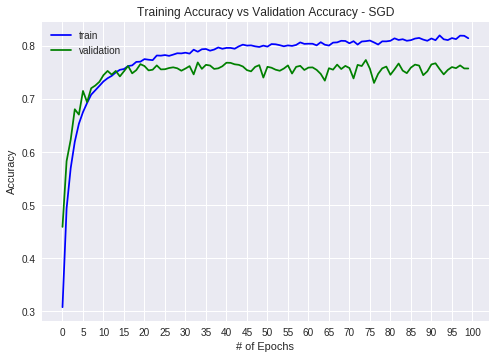

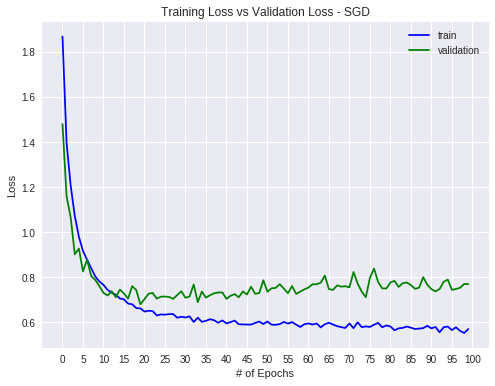

In [16]:
plt.figure(0)
plt.plot(cnn_nh.history['acc'],'b')
plt.plot(cnn_nh.history['val_acc'],'g')
plt.xticks(np.arange(0, 101, 5.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("# of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy - SGD")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(cnn_nh.history['loss'],'b')
plt.plot(cnn_nh.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 5.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss - SGD")
plt.legend(['train','validation'])
 
 
plt.show()

## Defining the model - Nadam

Same structure as defined before, the only difference is the optimization method being used.

In [0]:
def model_nadam():

  model = Sequential()

# block 1
  model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

# block 2
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

# block 3
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  
  nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004) 
  # Adam for backpropagation with added nesterov momentum (more at https://keras.io/optimizers/)
  # Adam paper https://arxiv.org/abs/1412.6980v8 (this very well may be overkill for this size of a problem)
  
  model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
  return model


## Training the model - Nadam

In [18]:
# Train model
cnn_na = model_nadam()
cnn_na.summary()
 
# Fit model
cnn_nah = cnn_na.fit(x_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_data=(x_test,y_test),
            shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        18496     
__________

50000/50000 [==============================] - 32s 643us/step - loss: 1.6953 - acc: 0.3741 - val_loss: 1.3831 - val_acc: 0.5017
Epoch 2/100
25184/50000 [==============>...............] - ETA: 14s - loss: 1.3587 - acc: 0.5095

50000/50000 [==============================] - 31s 624us/step - loss: 1.3291 - acc: 0.5224 - val_loss: 1.1981 - val_acc: 0.5716
Epoch 3/100
33440/50000 [===================>..........] - ETA: 9s - loss: 1.2084 - acc: 0.5687

50000/50000 [==============================] - 31s 619us/step - loss: 1.1979 - acc: 0.5733 - val_loss: 1.0791 - val_acc: 0.6257
Epoch 4/100
36512/50000 [====================>.........] - ETA: 7s - loss: 1.1313 - acc: 0.6028

50000/50000 [==============================] - 31s 621us/step - loss: 1.1233 - acc: 0.6063 - val_loss: 1.0385 - val_acc: 0.6299
Epoch 5/100
37632/50000 [=====================>........] - ETA: 7s - loss: 1.0649 - acc: 0.6244

50000/50000 [==============================] - 31s 623us/step - loss: 1.0636 - acc: 0.6268 - val_loss: 0.9711 - val_acc: 0.6600
Epoch 6/100
38080/50000 [=====================>........] - ETA: 7s - loss: 1.0280 - acc: 0.6361

50000/50000 [==============================] - 31s 627us/step - loss: 1.0234 - acc: 0.6384 - val_loss: 0.9291 - val_acc: 0.6718
Epoch 7/100
38208/50000 [=====================>........] - ETA: 6s - loss: 0.9965 - acc: 0.6482

50000/50000 [==============================] - 31s 611us/step - loss: 0.9979 - acc: 0.6473 - val_loss: 0.9109 - val_acc: 0.6855
Epoch 8/100
38336/50000 [======================>.......] - ETA: 6s - loss: 0.9632 - acc: 0.6591

50000/50000 [==============================] - 31s 612us/step - loss: 0.9659 - acc: 0.6595 - val_loss: 0.9529 - val_acc: 0.6704
Epoch 9/100
38336/50000 [======================>.......] - ETA: 6s - loss: 0.9506 - acc: 0.6684

50000/50000 [==============================] - 31s 611us/step - loss: 0.9454 - acc: 0.6699 - val_loss: 0.8679 - val_acc: 0.7035
Epoch 10/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.9349 - acc: 0.6756

50000/50000 [==============================] - 30s 604us/step - loss: 0.9393 - acc: 0.6743 - val_loss: 0.8636 - val_acc: 0.7013
Epoch 11/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.9178 - acc: 0.6791

50000/50000 [==============================] - 30s 608us/step - loss: 0.9198 - acc: 0.6791 - val_loss: 0.8516 - val_acc: 0.7047
Epoch 12/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8950 - acc: 0.6890

50000/50000 [==============================] - 30s 608us/step - loss: 0.9014 - acc: 0.6867 - val_loss: 0.8542 - val_acc: 0.7046
Epoch 13/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8961 - acc: 0.6874

50000/50000 [==============================] - 30s 606us/step - loss: 0.9005 - acc: 0.6853 - val_loss: 0.8848 - val_acc: 0.6914
Epoch 14/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8868 - acc: 0.6883

50000/50000 [==============================] - 30s 605us/step - loss: 0.8910 - acc: 0.6877 - val_loss: 0.8199 - val_acc: 0.7186
Epoch 15/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8725 - acc: 0.6944

50000/50000 [==============================] - 30s 604us/step - loss: 0.8729 - acc: 0.6938 - val_loss: 0.9248 - val_acc: 0.6963
Epoch 16/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8617 - acc: 0.7006

50000/50000 [==============================] - 30s 604us/step - loss: 0.8650 - acc: 0.6995 - val_loss: 0.8437 - val_acc: 0.7088
Epoch 17/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8516 - acc: 0.7050

50000/50000 [==============================] - 30s 605us/step - loss: 0.8567 - acc: 0.7027 - val_loss: 0.8135 - val_acc: 0.7216
Epoch 18/100
38112/50000 [=====================>........] - ETA: 6s - loss: 0.8475 - acc: 0.7016

50000/50000 [==============================] - 30s 610us/step - loss: 0.8499 - acc: 0.7016 - val_loss: 0.7891 - val_acc: 0.7262
Epoch 19/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8382 - acc: 0.7087

50000/50000 [==============================] - 30s 606us/step - loss: 0.8411 - acc: 0.7064 - val_loss: 0.8075 - val_acc: 0.7201
Epoch 20/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8310 - acc: 0.7098

50000/50000 [==============================] - 30s 604us/step - loss: 0.8332 - acc: 0.7095 - val_loss: 0.8325 - val_acc: 0.7146
Epoch 21/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8212 - acc: 0.7130

50000/50000 [==============================] - 30s 605us/step - loss: 0.8288 - acc: 0.7107 - val_loss: 0.8314 - val_acc: 0.7163
Epoch 22/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8264 - acc: 0.7136

50000/50000 [==============================] - 30s 607us/step - loss: 0.8279 - acc: 0.7125 - val_loss: 0.7965 - val_acc: 0.7264
Epoch 23/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8207 - acc: 0.7159

50000/50000 [==============================] - 30s 606us/step - loss: 0.8214 - acc: 0.7163 - val_loss: 0.8041 - val_acc: 0.7246
Epoch 24/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8071 - acc: 0.7182

50000/50000 [==============================] - 30s 603us/step - loss: 0.8136 - acc: 0.7172 - val_loss: 0.8211 - val_acc: 0.7212
Epoch 25/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8013 - acc: 0.7224

50000/50000 [==============================] - 30s 604us/step - loss: 0.8055 - acc: 0.7211 - val_loss: 0.7841 - val_acc: 0.7341
Epoch 26/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8037 - acc: 0.7190

50000/50000 [==============================] - 30s 605us/step - loss: 0.8057 - acc: 0.7185 - val_loss: 0.7982 - val_acc: 0.7292
Epoch 27/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.8018 - acc: 0.7202

50000/50000 [==============================] - 30s 601us/step - loss: 0.8001 - acc: 0.7217 - val_loss: 0.8140 - val_acc: 0.7249
Epoch 28/100
38112/50000 [=====================>........] - ETA: 6s - loss: 0.7882 - acc: 0.7256

50000/50000 [==============================] - 30s 603us/step - loss: 0.7959 - acc: 0.7224 - val_loss: 0.8484 - val_acc: 0.7114
Epoch 29/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7862 - acc: 0.7276

50000/50000 [==============================] - 30s 608us/step - loss: 0.7927 - acc: 0.7254 - val_loss: 0.7624 - val_acc: 0.7404
Epoch 30/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7854 - acc: 0.7287

50000/50000 [==============================] - 30s 600us/step - loss: 0.7911 - acc: 0.7264 - val_loss: 0.7922 - val_acc: 0.7301
Epoch 31/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7827 - acc: 0.7302

50000/50000 [==============================] - 30s 601us/step - loss: 0.7881 - acc: 0.7281 - val_loss: 0.8446 - val_acc: 0.7172
Epoch 32/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7863 - acc: 0.7277

50000/50000 [==============================] - 30s 606us/step - loss: 0.7886 - acc: 0.7268 - val_loss: 0.7709 - val_acc: 0.7381
Epoch 33/100
38112/50000 [=====================>........] - ETA: 6s - loss: 0.7730 - acc: 0.7308

50000/50000 [==============================] - 30s 603us/step - loss: 0.7769 - acc: 0.7291 - val_loss: 0.8132 - val_acc: 0.7252
Epoch 34/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7764 - acc: 0.7305

50000/50000 [==============================] - 30s 603us/step - loss: 0.7781 - acc: 0.7303 - val_loss: 0.8115 - val_acc: 0.7287
Epoch 35/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7585 - acc: 0.7344

50000/50000 [==============================] - 30s 603us/step - loss: 0.7626 - acc: 0.7353 - val_loss: 0.8062 - val_acc: 0.7285
Epoch 36/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7661 - acc: 0.7352

50000/50000 [==============================] - 30s 605us/step - loss: 0.7681 - acc: 0.7336 - val_loss: 0.8330 - val_acc: 0.7224
Epoch 37/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7690 - acc: 0.7349

50000/50000 [==============================] - 30s 605us/step - loss: 0.7669 - acc: 0.7360 - val_loss: 0.7759 - val_acc: 0.7323
Epoch 38/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7572 - acc: 0.7402

50000/50000 [==============================] - 30s 604us/step - loss: 0.7582 - acc: 0.7403 - val_loss: 0.7745 - val_acc: 0.7349
Epoch 39/100
38112/50000 [=====================>........] - ETA: 6s - loss: 0.7415 - acc: 0.7445

50000/50000 [==============================] - 30s 602us/step - loss: 0.7478 - acc: 0.7422 - val_loss: 0.7716 - val_acc: 0.7369
Epoch 40/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7368 - acc: 0.7461

50000/50000 [==============================] - 30s 603us/step - loss: 0.7481 - acc: 0.7431 - val_loss: 0.7795 - val_acc: 0.7396
Epoch 41/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7490 - acc: 0.7401

50000/50000 [==============================] - 31s 611us/step - loss: 0.7513 - acc: 0.7393 - val_loss: 0.7856 - val_acc: 0.7369
Epoch 42/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7433 - acc: 0.7447

50000/50000 [==============================] - 30s 608us/step - loss: 0.7469 - acc: 0.7424 - val_loss: 0.7863 - val_acc: 0.7343
Epoch 43/100
38112/50000 [=====================>........] - ETA: 6s - loss: 0.7533 - acc: 0.7388

50000/50000 [==============================] - 30s 605us/step - loss: 0.7560 - acc: 0.7394 - val_loss: 0.7958 - val_acc: 0.7315
Epoch 44/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7467 - acc: 0.7428

50000/50000 [==============================] - 30s 607us/step - loss: 0.7471 - acc: 0.7441 - val_loss: 0.8021 - val_acc: 0.7332
Epoch 45/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7412 - acc: 0.7439

50000/50000 [==============================] - 30s 604us/step - loss: 0.7412 - acc: 0.7446 - val_loss: 0.7940 - val_acc: 0.7393
Epoch 46/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7354 - acc: 0.7450

50000/50000 [==============================] - 30s 603us/step - loss: 0.7400 - acc: 0.7436 - val_loss: 0.8151 - val_acc: 0.7329
Epoch 47/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7267 - acc: 0.7492

50000/50000 [==============================] - 30s 602us/step - loss: 0.7335 - acc: 0.7472 - val_loss: 0.7706 - val_acc: 0.7422
Epoch 48/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7345 - acc: 0.7471

50000/50000 [==============================] - 30s 606us/step - loss: 0.7405 - acc: 0.7447 - val_loss: 0.7659 - val_acc: 0.7376
Epoch 49/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7140 - acc: 0.7547

50000/50000 [==============================] - 30s 605us/step - loss: 0.7258 - acc: 0.7510 - val_loss: 0.7595 - val_acc: 0.7456
Epoch 50/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7216 - acc: 0.7516

50000/50000 [==============================] - 30s 605us/step - loss: 0.7220 - acc: 0.7511 - val_loss: 0.7691 - val_acc: 0.7443
Epoch 51/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7261 - acc: 0.7526

50000/50000 [==============================] - 30s 603us/step - loss: 0.7307 - acc: 0.7506 - val_loss: 0.7862 - val_acc: 0.7368
Epoch 52/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7190 - acc: 0.7527

50000/50000 [==============================] - 30s 610us/step - loss: 0.7258 - acc: 0.7508 - val_loss: 0.7800 - val_acc: 0.7389
Epoch 53/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7202 - acc: 0.7541

50000/50000 [==============================] - 30s 604us/step - loss: 0.7248 - acc: 0.7521 - val_loss: 0.7605 - val_acc: 0.7456
Epoch 54/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7172 - acc: 0.7530

50000/50000 [==============================] - 30s 605us/step - loss: 0.7204 - acc: 0.7508 - val_loss: 0.7544 - val_acc: 0.7457
Epoch 55/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7174 - acc: 0.7512

50000/50000 [==============================] - 30s 603us/step - loss: 0.7200 - acc: 0.7509 - val_loss: 0.7546 - val_acc: 0.7503
Epoch 56/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7153 - acc: 0.7531

50000/50000 [==============================] - 30s 601us/step - loss: 0.7164 - acc: 0.7531 - val_loss: 0.7797 - val_acc: 0.7472
Epoch 57/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7077 - acc: 0.7560

50000/50000 [==============================] - 30s 603us/step - loss: 0.7152 - acc: 0.7536 - val_loss: 0.7865 - val_acc: 0.7376
Epoch 58/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7178 - acc: 0.7538

50000/50000 [==============================] - 30s 605us/step - loss: 0.7243 - acc: 0.7512 - val_loss: 0.8163 - val_acc: 0.7325
Epoch 59/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7099 - acc: 0.7568

50000/50000 [==============================] - 30s 608us/step - loss: 0.7117 - acc: 0.7571 - val_loss: 0.9102 - val_acc: 0.7098
Epoch 60/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7098 - acc: 0.7561

50000/50000 [==============================] - 30s 602us/step - loss: 0.7102 - acc: 0.7553 - val_loss: 0.7905 - val_acc: 0.7409
Epoch 61/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6962 - acc: 0.7625

50000/50000 [==============================] - 30s 598us/step - loss: 0.7016 - acc: 0.7598 - val_loss: 0.8058 - val_acc: 0.7301
Epoch 62/100
38176/50000 [=====================>........] - ETA: 6s - loss: 0.6980 - acc: 0.7592

50000/50000 [==============================] - 30s 598us/step - loss: 0.6997 - acc: 0.7577 - val_loss: 0.7793 - val_acc: 0.7391
Epoch 63/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7038 - acc: 0.7611

50000/50000 [==============================] - 30s 600us/step - loss: 0.7107 - acc: 0.7589 - val_loss: 0.8157 - val_acc: 0.7312
Epoch 64/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6957 - acc: 0.7605

50000/50000 [==============================] - 30s 607us/step - loss: 0.7017 - acc: 0.7592 - val_loss: 0.7649 - val_acc: 0.7468
Epoch 65/100
38112/50000 [=====================>........] - ETA: 6s - loss: 0.7000 - acc: 0.7630

50000/50000 [==============================] - 30s 596us/step - loss: 0.7046 - acc: 0.7613 - val_loss: 0.7916 - val_acc: 0.7385
Epoch 66/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7053 - acc: 0.7582

50000/50000 [==============================] - 30s 597us/step - loss: 0.7069 - acc: 0.7579 - val_loss: 0.8557 - val_acc: 0.7133
Epoch 67/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6977 - acc: 0.7626

50000/50000 [==============================] - 30s 597us/step - loss: 0.7027 - acc: 0.7618 - val_loss: 0.7740 - val_acc: 0.7472
Epoch 68/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7016 - acc: 0.7606

50000/50000 [==============================] - 30s 597us/step - loss: 0.7015 - acc: 0.7611 - val_loss: 0.7760 - val_acc: 0.7432
Epoch 69/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.7000 - acc: 0.7615

50000/50000 [==============================] - 30s 599us/step - loss: 0.7008 - acc: 0.7611 - val_loss: 0.8207 - val_acc: 0.7319
Epoch 70/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6936 - acc: 0.7635

50000/50000 [==============================] - 30s 599us/step - loss: 0.6973 - acc: 0.7634 - val_loss: 0.8332 - val_acc: 0.7291
Epoch 71/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6873 - acc: 0.7652

50000/50000 [==============================] - 30s 596us/step - loss: 0.6895 - acc: 0.7640 - val_loss: 0.7846 - val_acc: 0.7369
Epoch 72/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6944 - acc: 0.7621

50000/50000 [==============================] - 30s 599us/step - loss: 0.6958 - acc: 0.7615 - val_loss: 0.7585 - val_acc: 0.7526
Epoch 73/100
38176/50000 [=====================>........] - ETA: 6s - loss: 0.6852 - acc: 0.7627

50000/50000 [==============================] - 30s 599us/step - loss: 0.6950 - acc: 0.7607 - val_loss: 0.7730 - val_acc: 0.7458
Epoch 74/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6952 - acc: 0.7628

50000/50000 [==============================] - 30s 597us/step - loss: 0.6956 - acc: 0.7628 - val_loss: 0.8152 - val_acc: 0.7329
Epoch 75/100
38176/50000 [=====================>........] - ETA: 6s - loss: 0.6779 - acc: 0.7659

50000/50000 [==============================] - 30s 602us/step - loss: 0.6787 - acc: 0.7661 - val_loss: 0.7844 - val_acc: 0.7495
Epoch 76/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6836 - acc: 0.7660

50000/50000 [==============================] - 30s 599us/step - loss: 0.6983 - acc: 0.7617 - val_loss: 0.7954 - val_acc: 0.7320
Epoch 77/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6887 - acc: 0.7640

50000/50000 [==============================] - 30s 599us/step - loss: 0.6864 - acc: 0.7652 - val_loss: 0.7972 - val_acc: 0.7381
Epoch 78/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6947 - acc: 0.7621

50000/50000 [==============================] - 30s 599us/step - loss: 0.7012 - acc: 0.7601 - val_loss: 0.7942 - val_acc: 0.7355
Epoch 79/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6854 - acc: 0.7662

50000/50000 [==============================] - 30s 601us/step - loss: 0.6913 - acc: 0.7650 - val_loss: 0.7486 - val_acc: 0.7512
Epoch 80/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6758 - acc: 0.7690

50000/50000 [==============================] - 30s 598us/step - loss: 0.6801 - acc: 0.7690 - val_loss: 0.7634 - val_acc: 0.7492
Epoch 81/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6748 - acc: 0.7684

50000/50000 [==============================] - 30s 597us/step - loss: 0.6748 - acc: 0.7688 - val_loss: 0.8258 - val_acc: 0.7305
Epoch 82/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6842 - acc: 0.7675

50000/50000 [==============================] - 30s 599us/step - loss: 0.6987 - acc: 0.7627 - val_loss: 0.7760 - val_acc: 0.7448
Epoch 83/100
38176/50000 [=====================>........] - ETA: 6s - loss: 0.6666 - acc: 0.7723

50000/50000 [==============================] - 30s 599us/step - loss: 0.6726 - acc: 0.7692 - val_loss: 0.7827 - val_acc: 0.7439
Epoch 84/100
38112/50000 [=====================>........] - ETA: 6s - loss: 0.6822 - acc: 0.7680

50000/50000 [==============================] - 30s 597us/step - loss: 0.6819 - acc: 0.7691 - val_loss: 0.7885 - val_acc: 0.7461
Epoch 85/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6717 - acc: 0.7734

50000/50000 [==============================] - 30s 598us/step - loss: 0.6756 - acc: 0.7708 - val_loss: 0.8581 - val_acc: 0.7254
Epoch 86/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6855 - acc: 0.7646

50000/50000 [==============================] - 30s 596us/step - loss: 0.6845 - acc: 0.7651 - val_loss: 0.7701 - val_acc: 0.7482
Epoch 87/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6818 - acc: 0.7677

50000/50000 [==============================] - 30s 599us/step - loss: 0.6828 - acc: 0.7676 - val_loss: 0.8124 - val_acc: 0.7421
Epoch 88/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6747 - acc: 0.7707

50000/50000 [==============================] - 30s 601us/step - loss: 0.6752 - acc: 0.7706 - val_loss: 0.7796 - val_acc: 0.7464
Epoch 89/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6653 - acc: 0.7725

50000/50000 [==============================] - 30s 597us/step - loss: 0.6708 - acc: 0.7711 - val_loss: 0.8161 - val_acc: 0.7340
Epoch 90/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6645 - acc: 0.7740

50000/50000 [==============================] - 30s 597us/step - loss: 0.6675 - acc: 0.7739 - val_loss: 0.7851 - val_acc: 0.7443
Epoch 91/100
38112/50000 [=====================>........] - ETA: 6s - loss: 0.6686 - acc: 0.7727

50000/50000 [==============================] - 30s 596us/step - loss: 0.6693 - acc: 0.7716 - val_loss: 0.7928 - val_acc: 0.7403
Epoch 92/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6697 - acc: 0.7723

50000/50000 [==============================] - 30s 598us/step - loss: 0.6735 - acc: 0.7715 - val_loss: 0.7969 - val_acc: 0.7437
Epoch 93/100
38176/50000 [=====================>........] - ETA: 6s - loss: 0.6657 - acc: 0.7725

50000/50000 [==============================] - 30s 598us/step - loss: 0.6681 - acc: 0.7731 - val_loss: 0.7938 - val_acc: 0.7488
Epoch 94/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6687 - acc: 0.7731

50000/50000 [==============================] - 30s 595us/step - loss: 0.6739 - acc: 0.7716 - val_loss: 0.8110 - val_acc: 0.7388
Epoch 95/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6746 - acc: 0.7722

50000/50000 [==============================] - 30s 601us/step - loss: 0.6851 - acc: 0.7687 - val_loss: 0.8152 - val_acc: 0.7360
Epoch 96/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6762 - acc: 0.7728

50000/50000 [==============================] - 30s 598us/step - loss: 0.6739 - acc: 0.7732 - val_loss: 0.7902 - val_acc: 0.7402
Epoch 97/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6701 - acc: 0.7724

50000/50000 [==============================] - 30s 597us/step - loss: 0.6674 - acc: 0.7736 - val_loss: 0.7897 - val_acc: 0.7521
Epoch 98/100
38112/50000 [=====================>........] - ETA: 6s - loss: 0.6642 - acc: 0.7742

50000/50000 [==============================] - 30s 597us/step - loss: 0.6646 - acc: 0.7742 - val_loss: 0.8067 - val_acc: 0.7393
Epoch 99/100
38144/50000 [=====================>........] - ETA: 6s - loss: 0.6552 - acc: 0.7766

50000/50000 [==============================] - 30s 598us/step - loss: 0.6638 - acc: 0.7747 - val_loss: 0.8021 - val_acc: 0.7380
Epoch 100/100
37952/50000 [=====================>........] - ETA: 6s - loss: 0.6563 - acc: 0.7780

50000/50000 [==============================] - 30s 596us/step - loss: 0.6603 - acc: 0.7765 - val_loss: 0.7834 - val_acc: 0.7500


In [22]:
# os library allows us to interface with our operating system
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model_nadam.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
cnn_na.save(model_path)
print('Saved trained model at %s ' % model_path)

# output score for model
scores = cnn_na.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /content/saved_models/keras_cifar10_trained_model_nadam.h5 
10000/10000 [==============================] - 2s 175us/step
Test loss: 0.783402370595932
Test accuracy: 0.75


## Visualizing the results - Nadam

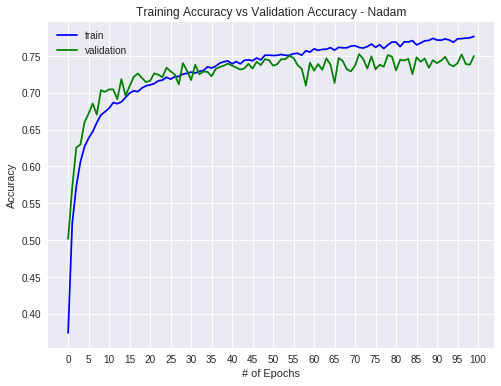

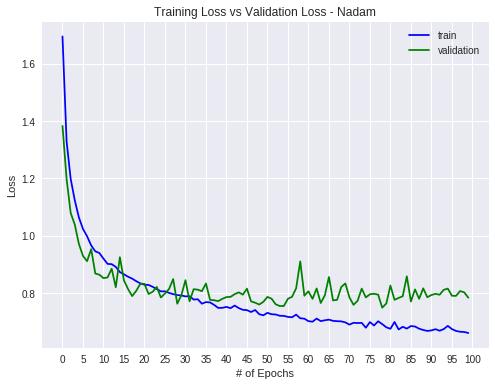

In [20]:

plt.figure(0)
plt.plot(cnn_nah.history['acc'],'b')
plt.plot(cnn_nah.history['val_acc'],'g')
plt.xticks(np.arange(0, 101, 5.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("# of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy - Nadam")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(cnn_nah.history['loss'],'b')
plt.plot(cnn_nah.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 5.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss - Nadam")
plt.legend(['train','validation'])
 
 
plt.show()

## Comparing the two optimizers

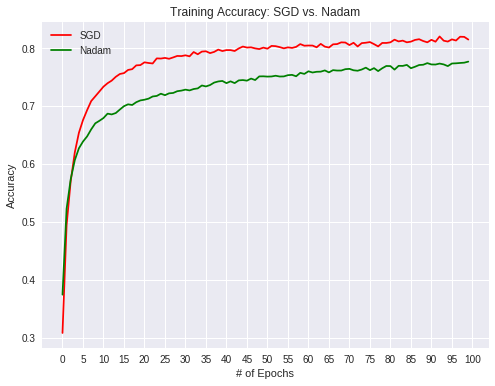

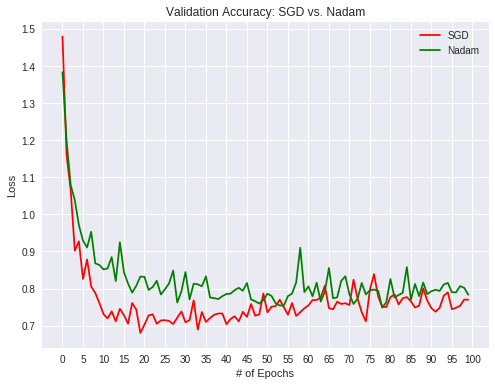

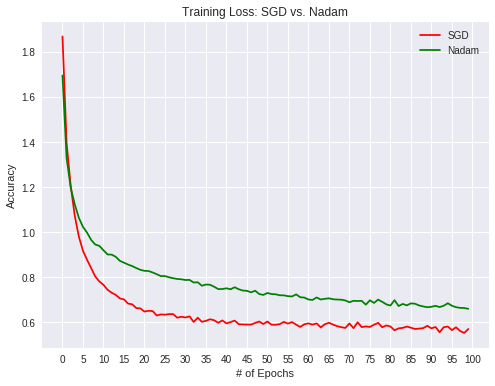

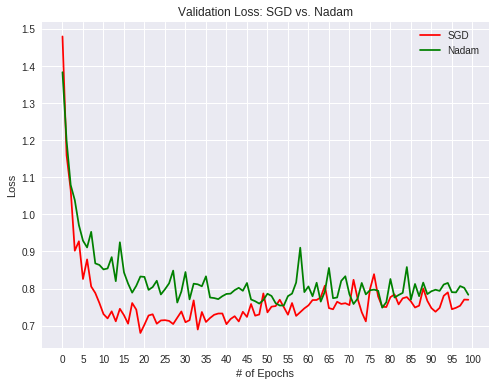

In [21]:
plt.figure(0)
plt.plot(cnn_nh.history['acc'],'r')
plt.plot(cnn_nah.history['acc'],'g')
plt.xticks(np.arange(0, 101, 5.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("# of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy: SGD vs. Nadam")
plt.legend(['SGD','Nadam'])
 
 
plt.figure(1)
plt.plot(cnn_nh.history['val_loss'],'r')
plt.plot(cnn_nah.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 5.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.title("Validation Accuracy: SGD vs. Nadam")
plt.legend(['SGD','Nadam'])

plt.figure(2)
plt.plot(cnn_nh.history['loss'],'r')
plt.plot(cnn_nah.history['loss'],'g')
plt.xticks(np.arange(0, 101, 5.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("# of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Loss: SGD vs. Nadam")
plt.legend(['SGD','Nadam'])
 
 
plt.figure(3)
plt.plot(cnn_nh.history['val_loss'],'r')
plt.plot(cnn_nah.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 5.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss: SGD vs. Nadam")
plt.legend(['SGD','Nadam'])
 
 
plt.show()

## Conclusions


* The epoch size of 100 was much larger than necessary
*   SGD ended with a validation accuracy of 75.76%, compared to Nadam that had 75.00% accuracy
*   SGD converged faster and began to slightly overfit at around 20 epochs
* Whereas Nadam took around 50 epochs to fully converge
* In the future for problems of this size I would probably choose SGD as it converges faster and trains faster

If I wanted to continue to increase my accuracy there are several directions I could head in:
* Residual Neural Networks
* Better Data Augmentation
* Deeper Layers
* Better hyper-parameter tuning
* Using a pretrained architecture
* Experiment with more optimizers

Overall, I'm satisfied with what I've learned through this project as an introduction to CNNs and image recognition. My initial accuracy using the image averages was 24.87%, which means my CNN with a 75.76% accuracy was a 304.62% improvement. If I were to explore it further I would use the larger ImageNet dataset and try some more advanced architectures like ResNet or AlexNet.

